# Comparison between different background subtraction methods

Thanks to the wide variety of background subtraction methods available, we explored several approaches and selected the most commonly used and efficient ones. 

OpenCV provides a rich set of built-in implementations, which made it relatively easy to test multiple methods and compare their performance. After experimenting with various techniques, we decided to focus on three: **MOG2, CNT, and Temporal Median Filter**. 

These methods stood out as the best candidates for our task, as other approaches often proved to be unnecessarily complex or computationally heavy while yielding results similar to these more lightweight solutions. 

In this notebook, we will analyze the performance of these three methods, discuss their strengths and weaknesses, and explain how combining them helped us achieve more robust and accurate results.

In [3]:
# importing necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_ubyte, filters
import cv2.bgsegm

In [4]:
# extraction of some frames to visualize the comparison between the three methods
video_path = "../video/rilevamento-intrusioni-video.wm"
cap = cv2.VideoCapture(video_path)

assert cap.isOpened(), "Not opened!"

fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
length = total_frame_count / fps

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

frameIds = [
    79,     # full body, noise
    318,    # full body, noise, book
    340,    # full body, noise, book
    360     # full body, noise, book
]

frames = []
for fid in frameIds:
    cap.set(cv2.CAP_PROP_POS_FRAMES, fid)
    ret, frame = cap.read()
    if frame is not None:
        frames.append(frame)


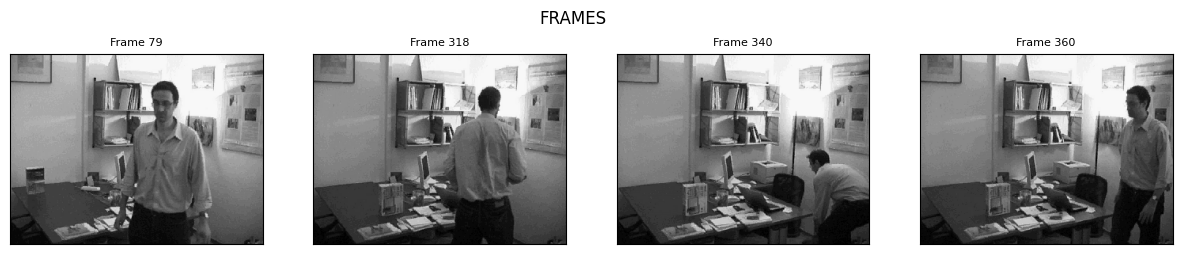

In [5]:
# utils method to visualize all the frames togheter
def show_subplots(title, frameIds, frames):
    fig, axs = plt.subplots(1, len(frames), figsize=(15, 2.5))
    fig.suptitle(title, ha='center',va='bottom')

    for i, ax, frame in zip(range(len(frames)), axs, frames):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_title(f"Frame {frameIds[i]}", fontsize=8)
        ax.imshow(frame, cmap="grey")

    plt.show()

show_subplots("FRAMES", frameIds, frames)

## MOG2

MOG2 is a background/foreground segmentation algorithm, where a pixel is classified as background if its value matches the probability density function modeled by a **Gaussian Mixture Model** (GMM). Each pixel's GMM consists of multiple Gaussian components, updated recursively based on a learning rate. The algorithm adapts the number of components dynamically, balancing accuracy and efficiency.  

This approach effectively models complex backgrounds by adapting to dynamic scenes. The use of Gaussian Mixture Models (GMMs) allows for flexibility in capturing a wide range of pixel variations, even in environments with small changes. The ability to dynamically adjust the number of components for each pixel ensures accurate background representation across different scene complexities. Additionally, the **compact representation** of the GMM enables efficient processing, making it well-suited for real-time applications. While there may be challenges in handling highly dynamic backgrounds or fine details, the algorithm's ability to adapt to scene complexity and provide robust performance in most scenarios is a significant advantage.

— Source: ["Eﬃcient adaptive density estimation per image pixel for the task of background subtraction"](https://www.sciencedirect.com/science/article/pii/S0167865505003521) by Zoran Zivkovic and Ferdinand van der Heijden (2005). 

In [6]:
# -------------------------------
# |        MOG2: CONFIG         |
# -------------------------------
BLACK = 0
LEARNING_PHASE = 5 * fps                        # Initialization phase to estimate the reference frame

In [7]:
def mog2_background_subtractor():
    mog2 = cv2.createBackgroundSubtractorMOG2()
    
    # [ HISTORY ]
    # Set's the number of last frames that affect the background model.
    mog2.setHistory(LEARNING_PHASE)

    # [ BACKGROUND RATIO ] 
    # Determines the portion of the history used to model the background, directly influencing how quickly new objects are integrated into it.
    # A higher backgroundRatio results in a more stable model that is less sensitive to temporary changes, while a lower backgroundRatio allows for faster adaptation to new objects. 
    # If a foreground pixel maintains a nearly constant value for approximately backgroundRatio × history frames, it is reclassified as background and incorporated into the model as a 
    # new Gaussian component.
    mog2.setBackgroundRatio(70 / 100)             # cf=0.3 --> background_ratio=0.7

    # [ SHADOWS ]
    mog2.setDetectShadows(True)
    mog2.setShadowThreshold(0.70)                 # A lower value may help in detecting more shadows.
    mog2.setShadowValue(BLACK)                    # Detect shadows and hide them

    # [ THRESHOLDS ]
    # The main threshold on the squared Mahalanobis distance to decide if the sample is 
    # well described by the background model or not. 
    mog2.setVarThreshold(4.5**2)                  # default: 16

    return mog2

# SETUP - MOG2 Background Subtractor
mog2 = mog2_background_subtractor()

Released Video Resource


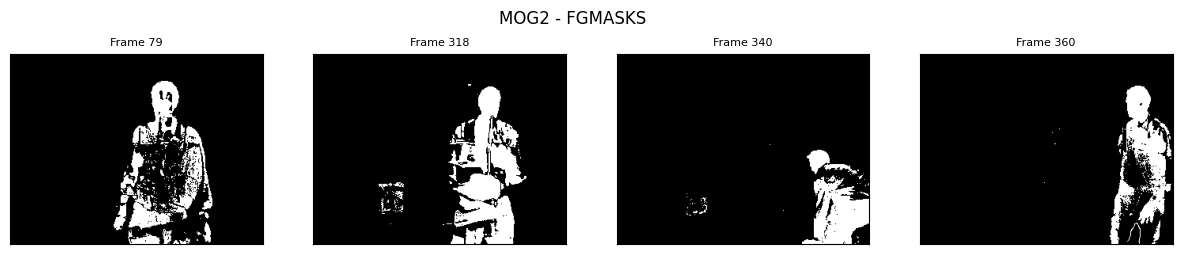

In [8]:
def mog2_fgmasks(frameIds, fgmasks):
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    frame_count = 0
    while(cap.isOpened()):
        ret, frame_original = cap.read()
        if not ret or frame_original is None:
            # cap.release()
            print("Released Video Resource")
            break

        frame = cv2.cvtColor(frame_original, cv2.COLOR_BGR2GRAY)
        frame = cv2.bilateralFilter(frame, d=3, sigmaSpace=75, sigmaColor=75)

        mog2_fgmask = mog2.apply(frame, -1)

        if frame_count in frameIds:
            fgmasks.append(mog2_fgmask)

        frame_count += 1

fgmasks = []
mog2_fgmasks(frameIds, fgmasks)

show_subplots("MOG2 - FGMASKS", frameIds, fgmasks)

The MOG2 method provides quiet well-defined **contours** for the person, effectively **handling lighting changes** and maintaining a **low noise level**. However, the figure is not always fully captured, with some parts appearing fragmented or eroded, especially in areas with lower contrast. 

Beyond that, objects like books quickly merge into the background, as MOG2 updates its model dynamically, making it less suitable for tracking temporary moving objects. While the algorithm effectively reduces false positives, it struggles with slow movements, occasionally absorbing them into the background. 

## TemporalMedian 

The TemporalMedian Background Subtraction method works by calculating the median of pixel values over a series of frames to identify background pixels. By focusing on stable pixel values, it effectively separates foreground elements that deviate from the typical scene, making it **robust against noise and gradual lighting changes**. This method is simple and computationally efficient, making it a good choice for static or slowly changing backgrounds.

However, the method has limitations in dynamic environments. It struggles with rapidly changing scenes or fast-moving objects since the median might not adapt quickly enough to sudden changes. Additionally, it may have difficulty distinguishing between foreground objects and parts of the background that change over time, such as lights. While effective in controlled settings, it’s less suitable for complex, high-speed motion detection compared to more advanced methods.

In [9]:
# -------------------------------
# |   TEMPORAL MEDIAN: CONFIG   |
# -------------------------------
MAX_HISTORY = fps * 3
STATIC_THRESHOLD = 40                           # used in the absolute difference
STATIC_THRESHOLD_HYSTERESIS = 30

font = cv2.FONT_HERSHEY_SIMPLEX

In [10]:
def temporal_median_background_subtraction(frame, background, args):
    
    # absolute difference between the frame and the background 
    diff = cv2.absdiff(frame, background)

    # threshold to segment background and foreground
    (t_low, t_high) = args
    hysteresis = filters.apply_hysteresis_threshold(diff, t_low, t_high)
    fgmask = img_as_ubyte(hysteresis)

    return fgmask

Released Video Resource


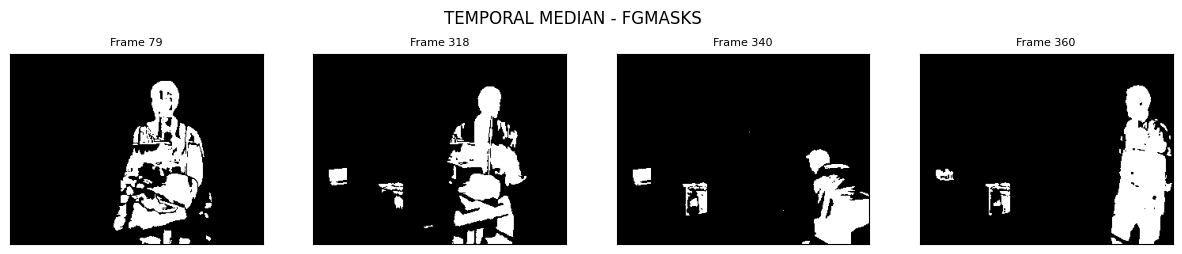

In [11]:
def temporalMedian_fgmasks(frameIds, fgmasks):
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    buffer = []
    temporalMedianBackground = None
    skip_frames = 0
    frame_count = 0

    while(cap.isOpened()):
        ret, frame_original = cap.read()
        if not ret or frame_original is None:
            # cap.release()
            print("Released Video Resource")
            break

        # preprocessing
        frame = cv2.cvtColor(frame_original, cv2.COLOR_BGR2GRAY)
        frame = cv2.bilateralFilter(frame, d=3, sigmaSpace=75, sigmaColor=75)

        skip_frames += 1
        
        if len(buffer) == 0 or skip_frames == fps//2:
            skip_frames = 0
            buffer.append(frame)
            if len(buffer) > MAX_HISTORY:
                buffer.pop(0)
            temporalMedianBackground = np.median(buffer, axis=0).astype(dtype=np.uint8)

        args = (STATIC_THRESHOLD_HYSTERESIS, STATIC_THRESHOLD)
        tmb_fgmask = temporal_median_background_subtraction(frame, temporalMedianBackground, args)
        
        if frame_count in frameIds:
            fgmasks.append(tmb_fgmask)

        frame_count += 1

fgmasks = []
temporalMedian_fgmasks(frameIds, fgmasks)

show_subplots("TEMPORAL MEDIAN - FGMASKS", frameIds, fgmasks)

The Temporal Median method provides a fuller representation of the person, maintaining **more details** while effectively **handling lighting changes** and **reducing noise**. 

Contours appear soft and not really well defined, which can make object boundaries less sharp. Temporary objects, such as books, remain visible for long time before blending into the background, making this approach useful for tracking elements that shouldn’t disappear too quickly. 

Overall, this method offers a stable foreground extraction, prioritizing persistence and completeness over rapid adaptation.

## CNT

BackgroundSubtractorCNT is an efficient background subtraction algorithm designed for speed and simplicity. Unlike MOG2, which models pixel color distributions over time, CNT relies on a frame count approach: if a pixel remains unchanged for a certain number of frames (within a tolerance for lighting variations), it is classified as background. This makes it computationally lighter, especially on low-end hardware like the Raspberry Pi, where it has been shown to run **more than twice as fast** as MOG2.  

While MOG2 provides better adaptation to complex dynamic backgrounds, CNT is optimized for performance, benefiting from parallelization when sufficient processing power is available. However, careful tuning of its parameters is necessary to balance responsiveness and background stability, as rapid changes can introduce ghosting effects. Thanks to its lightweight design and C++ optimizations, CNT is an excellent choice for real-time applications where speed is critical.

— Source: [BackgroundSubtractorCNT Documentation](https://sagi-z.github.io/BackgroundSubtractorCNT/)

In [12]:
# -------------------------------
# |        CNT : CONFIG         |
# -------------------------------

MIN_STABILITY = fps // 5
MAX_STABILITY = MIN_STABILITY * 60             # suggested default value in the documentation

In [13]:
def cnt_background_subtractor():
    cnt = cv2.bgsegm.createBackgroundSubtractorCNT()

    # [ PARALLEL ]
    # Determines if we're parallelizing the algorithm.
    # Setting `isParallel=True` leverages automatic parallelization for convenience and performance, 
    # utilizing available processing power without manual optimization.
    cnt.setIsParallel(True)
    
    # [ MAX PIXEL STABILITY ]
    # Maximum allowed credit for a pixel in history.
    # In other word, maximum time an object must remain static before being considered part of the background instead of the foreground.
    # Setting useHistory to False, the MaxPixelStability parameter will just be ignored.
    cnt.setMaxPixelStability(MAX_STABILITY)

    # [ MIN PIXEL STABILITY ]
    # Number of frames with same pixel color to consider stable.
    # In other word, this value represents the number of frames to wait when a pixel is not changing before marking it as background.
    # The value of minPixelStability = FPS/5 is chosen to minimize ghosting effects when useHistory=False. 
    # Since disabling history weakens background distinction, a lower minPixelStability ensures that transient foreground objects fade out faster, 
    # improving responsiveness while maintaining background clarity.
    cnt.setMinPixelStability(MIN_STABILITY)
    
    # [ HISTORY ]
    # Determines if we're giving a pixel credit for being stable for a long time
    # We decided to set useHistory to False so the model updates instantly without long-term memory, 
    # allowing faster adaptation as new objects are immediately detected as foreground.
    cnt.setUseHistory(False)

    return cnt

# SETUP - CNT Background Subtractor
cnt = cnt_background_subtractor()

Released Video Resource


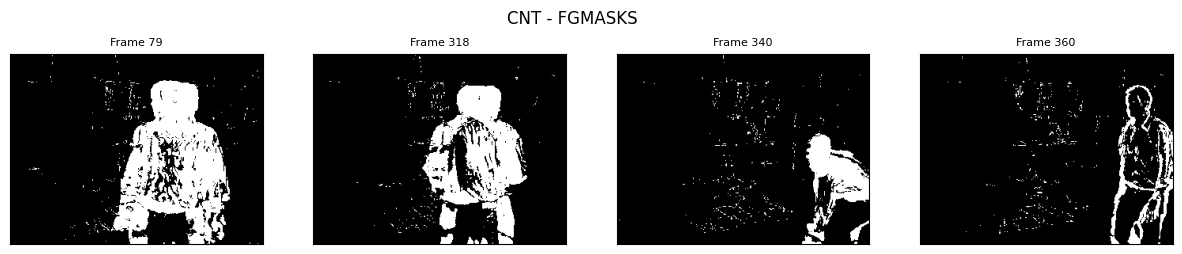

In [14]:
def cnt_fgmasks(frameIds, fgmasks):
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    frame_count = 0
    while(cap.isOpened()):
        ret, frame_original = cap.read()
        if not ret or frame_original is None:
            # cap.release()
            print("Released Video Resource")
            break
        
        # preprocessing
        frame = cv2.cvtColor(frame_original, cv2.COLOR_BGR2GRAY)
        frame = cv2.bilateralFilter(frame, d=3, sigmaSpace=75, sigmaColor=75)

        cnt_fgmask = cnt.apply(frame, learningRate = 0) # learningRate = 0 suggested from the documentation when using useHistory = False
        
        if frame_count in frameIds:
            fgmasks.append(cnt_fgmask)

        frame_count += 1

fgmasks = []
cnt_fgmasks(frameIds, fgmasks)

show_subplots("CNT - FGMASKS", frameIds, fgmasks)

The CNT method shows significant **noise**, with background artifacts persisting across frames and affecting overall clarity. While certain areas, like the shirt, are well-filled and retain a strong presence in the foreground, others, such as the pants, appear incomplete or missing. 

**Ghosting** effects are evident, suggesting difficulties in distinguishing moving objects from the background. 

Compared to the other methods, these results appear less reliable, as the segmentation lacks consistency and introduces excessive noise, making it less effective for stable foreground extraction.

In [15]:
# video release 
cap.release()

## Results and Conclusion

The **CNT** method proved ineffective due to excessive ghosting, noise, and incomplete foreground segmentation, often leaving parts of the image entirely empty and failing to detect objects like books, making it unsuitable for our needs. 

The **Temporal Median** approach performed well, particularly because it retained books in the foreground for a longer period, while **MOG2** also yielded good results, especially in accurately capturing the person, though it quickly discarded books as background. 

Our objective was to obtain a well-defined representation of the person while ensuring that moved objects, like books, remained in the foreground for an extended period rather than just a few frames. This led us to a combined approach leveraging both MOG2 and Temporal Median, using their differences to identify and maintain objects that had been moved and so should remain in the foreground permanently. 
To achieve this, MOG2 was primarily used to define a clear and precise silhouette of the person, allowing us to compute a reliable region of interest (ROI) around them, effectively making MOG2 a detector for fast-moving elements such as the person. On the other hand, the Temporal Median method focused on extracting all foreground elements, particularly those that persisted over time. By subtracting MOG2’s output from the Temporal Median result, we identified long-term objects like books, which were then added to the base foreground mask to ensure they remained consistently detected even in later frames. Additionally, within the person’s ROI, an OR operation between MOG2 and Temporal Median helped fill in missing parts of the figure, improving completeness while maintaining accurate segmentation.